<a href="https://colab.research.google.com/github/connorrupnow/hotplate_PID_simulation/blob/master/hotplate_PID_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

1. Run the first two cells (helper functions and modelling functions)
2. Mess around with cells 3+. The adjustable parameters are listed and described above cell 3 under "Implementing the simulation"

# Motivation

We have a hotplate that is controlled by a PID controller in order to precisely set and maintain the surface temperature. However, this tuning of the PID parameters is causing the surface temperature to osciallate by up to 20°C. Our experiments are highly sensitive to temperature, thus this 20°C temperature swing is unnacceptable. My ultimate goal is to reduce temperature oscillations to less than 5°C.

I want to tune the PID parameters for the hot plate controller, but each test of a new set of parameters takes around 4 hours. I have to wait for the hot plate to fully heat up from 20°C to around 200°C and then wait for it to cool down again. A hotplate is a relatively simple heat transfer problem, therefore if I can model it in simulation, I can simulate what the surface temperature will be over time. With this simuation, I can test a set of PID parameters in seconds rather than hours. This will allow me to quickly find an good set of PID parameters than will let me reduce temperature oscillations to less than 5°C.

# Setting up the problem

Modelling a hot plate using the heat equation

$$\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} , \alpha = \frac{k}{\rho C_p} $$

$$\rho C_p \frac{\partial T}{\partial t} = k \nabla^2  T$$

where $T$ is our temperature variable, $t$ is our time variable, $x$ is the space variable, and $\alpha$ is the temperature diffusion coefficient.

Our materials starts off at room temperature, thus our initial condition is,

$$ T(x,t=0) = T_{room}$$

The material is placed on a hot plate specifying that the solution
$T$ has constant flux at the hot plate boundary. The boundary condition is: 


$$\frac{\partial T}{\partial x}\Bigg|_{x = 0} = Q \cdotp \Pi(t) \space \space where \space \space \Pi(t) = 
 \begin{cases} 
      0 & t\leq t_{on} \\
      ax & 0\leq t\leq t_{warmup} \\
      1 &   t_{warmup} \leq t_{off} \\ 
      -bx & t_{off} \leq t\leq t_{off} + f_{cooldown}t_{warmup} \\
   \end{cases}
$$

Since the hotplate does not instantly go from 0 to 100% power, I added a $\Pi$ term that essentially forces the hotplate to "warmup" by assuming it goes from 0% to 100% power linearly over some time $t_{warmup}$. where $a = \frac{1}{t_{warmup}}$ and $b = \frac{a}{f_{cooldown}}$. If $t_{warmup}$ is 100 and $f_{cooldown}$ is 2 that means that when the hotplate turns on it will take 100s for it to go from 0% to 100% power and 200s to go from 100% to 0% power. The $\Pi$ function in practice is very simple and a plot is shown below once the helper function cell is run.

The other side of the material is open to the environment and thus is also a neumann boundary condition.

$$\frac{\partial T}{\partial x}\Bigg|_{x = L} = h \Delta T$$

$$\frac{\partial T}{\partial x}\Bigg|_{x = L} = h (T_{surface} - T_{environment})$$

where $h$ is the heat transfer coefficient and $\Delta T$ is the difference between the surface temperature environment temperature. For general indoor air environments $h$ is generally between 1 and 10. 



# Helper functions

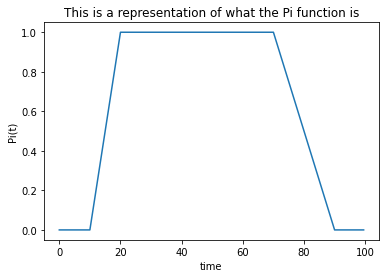

In [ ]:
#import packages
!pip install simple-PID
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from simple_pid import PID
from scipy.signal import find_peaks

def pi_function(dt,t_warmup,previous_pi_val,state, cooldown_factor=2):
  # inputs:
    # dt = timestep
    # t_warmup = the length of time it takes for the hotplate to go 0 to 100%
    # previous_pi_val = the value of pi from the previous iteration so it can know the slope
    # state = 1 or 0. state of the hotplate (on/off)
    # cooldown_factor = the ratio of cooldown slope to warmup slope. 1 means both slopes are the same. 2 means the cooldown slope is half the slope of the warmup.
    
    a = 1/t_warmup
    b = a/cooldown_factor

    if state == 1:
      if previous_pi_val < 1:
        pi_val = a*dt + previous_pi_val
      else:
        pi_val = 1



    if state == 0:
      if previous_pi_val > 0:
        pi_val = previous_pi_val - b*dt
      else:
        pi_val = 0

    if pi_val < 0:
      pi_val = 0
    if pi_val > 1:
      pi_val = 1
    
    return pi_val

dt = 0.5
t_warmup = 10
state=0
pi_list = [0]
t_list = [0]
for i in range(200):
  t_list.append(i*dt)

  if t_list[-1] > 10:
    state = 1
  
  if t_list[-1] > 70:
    state = 0

  pi_list.append(pi_function(dt,t_warmup,pi_list[-1],state))

plt.plot(t_list,pi_list)
plt.xlabel('time')
plt.title('This is a representation of what the Pi function is')
plt.ylabel('Pi(t)')

def generate_temperature_plot(T_list, x, tspan, T_setpoint):
  
  node_of_interest = len(x)-1
  POI = node_of_interest
  fig,ax = plt.subplots(1,2,figsize=(15,5))
  for i in range(0, len(T_list.T)):
      ax[0].plot(x, T_list.T[i])

  ax[0].scatter(x[POI],T_list.T[-1][POI])
  ax[1].plot(tspan,T_list[POI,:])
  if T_setpoint > 22:
    ax[1].axhline(y=T_setpoint, color='r', linestyle='--',alpha=0.5)

  ax[0].set_xlabel('length (m)')
  ax[0].set_ylabel('temperature (°C)')
  ax[1].set_xlabel('time (s)')
  ax[1].set_ylabel('temperature (°C)')

def T_surface_plot(tspan,T_surface,setpoint=0):
  fig,ax = plt.subplots() # figsize=(5,2)
  ax.plot(tspan,T_surface)
  ax.set_xlabel('time (s)')
  ax.set_ylabel('surface temperature (°C)')
  if setpoint > 0:
    ax.axhline(y=setpoint, color='r', linestyle='--',alpha=0.5)

def generate_temperature_animation(T_list, x, tspan,T_setpoint,interval=33):
  #TODO: plot the T_setpoint in the animation

  node_of_interest = len(x)-1
  POI = node_of_interest
  T_max = np.max(T_list)*1.2
  dx = x[1]-x[0]
  dt = tspan[1] - tspan[0]

  # create a figure and axes
  fig = plt.figure(figsize=(12,5))
  ax1 = plt.subplot(1,2,1)   
  ax2 = plt.subplot(1,2,2)

  # set up the subplots as needed
  ax1.set_xlim(( 0, x[-1]))            
  ax1.set_ylim((0, T_max))
  ax1.set_xlabel('x')
  ax1.set_ylabel('temperature')
  ax1.set_title('temperature evolving over time')

  ax2.set_xlim((0,tspan[-1]))
  ax2.set_ylim((0,T_max))
  ax2.set_xlabel('t')
  ax2.set_ylabel('temperature')
  ax2.set_title('temperature at edge of block')


  # create objects that will change in the animation. These are
  # initially empty, and will be given new values for each frame
  # in the animation.
  txt1 = ax1.text(0.85, 0.9,'',ha='center', va='center', transform=ax1.transAxes) 
  txt2 = ax2.text(0.85, 0.9,'',ha='center', va='center', transform=ax2.transAxes) 
  line1, = ax1.plot([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects
  line2, = ax2.plot([], [], 'b', lw=2)
  pt1, = ax1.plot([], [], 'r.', ms=20)
  pt2, = ax2.plot([], [], 'r.', ms=20)

  # define function to draw each frame

  def drawframe(n):
    
    line1.set_data(x,T_list[:,n]) # T vs x
    line2.set_data(tspan[0:n],T_list[POI,0:n]) # T vs t
    
    POI_Temp = T_list[POI,n] # POI on x
    pt1.set_data(POI*dx,POI_Temp)
    pt2.set_data(n*dt,POI_Temp)

    txt1.set_text('time = %.0f s' % (n*dt))
    txt2.set_text('T = %.1f °C' % (POI_Temp))

    return (line1,line2,pt1,pt2)

  # create animiation object and render in HTML video
  anim = animation.FuncAnimation(fig, drawframe, frames=len(tspan), interval=interval, blit=True)
  plt.close()
  return anim

def PID_metrics(T_surface,setpoint,dt=3):
  
  #initial overshoot
  peaks, _ = find_peaks(T_surface,prominence=0.5)
  if len(peaks) > 0:
    initial_overshoot = T_surface[peaks[0]] - setpoint
  else:
    initial_overshoot = 0

  valleys, _ = find_peaks(-np.array(T_surface),prominence=0.5)
  if len(peaks) > 0:
    if len(valleys) > 0:
      initial_swing = T_surface[peaks[0]] - T_surface[valleys[0]]
    else:
      initial_swing = initial_overshoot
  else:
    initial_swing = 0

  # time to reach setpoint
  setpoint_reached = np.argmax(np.array(T_surface)>setpoint)
  time_to_setpoint = setpoint_reached*dt

  T_max = max(T_surface[setpoint_reached:])
  T_min = min(T_surface[setpoint_reached:])
  max_swing = T_max - T_min
  print('Max temp: %.1f °C' % T_max)
  print('Min temp: %.1f °C' % T_min)
  print('Temp range: %.1f °C' % max_swing)

  print('initial overshoot: %.1f °C' % initial_overshoot)
  print('initial swing: %.1f °C' % initial_swing)
  print('time to setpoint: %.0f s (index %.0f)' % (time_to_setpoint,setpoint_reached))
  
  RMSE1 = np.sqrt(((np.subtract(T_surface[setpoint_reached:setpoint_reached+int(30*60/dt)],setpoint)) ** 2).mean()) #first 30 minutes
  RMSE2 = np.sqrt(((np.subtract(T_surface[setpoint_reached:setpoint_reached+int(60*60/dt)],setpoint)) ** 2).mean()) #first 1 hour
  RMSE3 = np.sqrt(((np.subtract(T_surface[setpoint_reached:setpoint_reached+int(120*60/dt)],setpoint)) ** 2).mean()) #first 2 hours
  RMSE4 = np.sqrt(((np.subtract(T_surface[(setpoint_reached+int(90*60/dt)):(setpoint_reached+int(120*60/dt)+int(30*60/dt))],setpoint)) ** 2).mean()) #30 min RMSE after 90 mins

  avg_temp = np.average(T_surface[setpoint_reached:])
  temp_diff = avg_temp - setpoint

  print('30 min RMSE: %.1f °C' % RMSE1)
  print('60 min RMSE: %.1f °C' % RMSE2)
  print('2 hour RMSE: %.1f °C' % RMSE3)
  print('after 90 min RMSE: %.4f °C' % RMSE4)
  print('Average temp: %.1f °C' % avg_temp)
  print('temp diff: %.1f °C' % temp_diff)


# Implicit Finite Difference

We can convert our continuous form of $\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} $ to a discrete version by using a first order taylor expansion for the time derivative and second order taylor expansion for the spacial double derivative

$$ \frac{T_{j}^{n+1} - T_{j}^{n}}{\Delta t} = \alpha  \frac{T_{j+1}^{n+1} - 2 
T_{j}^{n+1} + T_{j-1}^{n+1}}{(\Delta x)^2} $$

we can seperate time $n$ from time step $n+1$ to achieve the following formula.

$$
c T_{j-1}^{n+1} - (1+2c) T_{j}^{n+1} + c T_{j-1}^{n+1} = - T_{j}^{n}
$$

where $c = \frac{\alpha \Delta t}{(\Delta x)^2}$

Producing the formula above for each individual spacial node in the system, we acheive a system of equations that can be organized in the matrix below. Each row represents a node in space. The top and bottom rows represent the boundary conditions. The RHS of the equation you can see where the boundary conditions were added.

$$
\begin{bmatrix}
-(1+2c) & 2c & 0  & \cdots & 0 & 0 \\
c & -(1+2c) & c & 0 & \cdots & 0 \\
0 & c & -(1+2c) & c  & 0 & 0 \\
0 & 0 & \ddots & \ddots & \ddots & 0 \\
0 & \cdots & 0 & c & -(1+2c) & c \\
0 & 0 & \cdots & 0 & 2c & -(1+2c)
\end{bmatrix}
\begin{bmatrix}
T_0^{n+1} \\
T_1^{n+1} \\
T_2^{n+1} \\
\vdots \\
T_{J-1}^{n+1} \\
T_{J}^{n+1}
\end{bmatrix} =
\begin{bmatrix}
-T_0^{n} - 2 \Delta x c Q_{hotplate} \Pi \\
-T_1^{n} \\
-T_2^{n} \\
\vdots \\
-T_{J-1}^{n} \\
-T_{J}^{n} - 2 \Delta x c h_{air} \Delta T
\end{bmatrix}
$$

Using typical linear algebra techniques, we can solve for $T^{n+1}$ at ever point in space. The implicit finite difference method is unconditionally stable

<!-- rhs[0] = -1*T_old[0] - 2*q_hotplate*dx*c*pi_val
rhs[-1] = -1*T_old[-1] - 2*q_air*dx*c -->

In [ ]:
def initialize_A(c, num_nodes):
    A = np.zeros([num_nodes,num_nodes])
    for i in range(1,num_nodes-1):
        A[i,i-1] = c
        A[i,i] = -(1+2*c)
        A[i,i+1] = c

    # neumann BC using central diff
    A[0,0] = -(1+2*c)
    A[0,1] = 2*c
    A[num_nodes-1,num_nodes-1] = -(1+ 2*c)
    A[num_nodes-1,num_nodes-2] = 2*c
    
    return A

def iterate_heat_eqn(hotplate_state,
                     T_old,
                     pi_old,
                     A,
                     x,
                     c,
                     q_hotplate,
                     h_air,
                     num_nodes,
                     dt,
                     t_warmup=1e-10,
                     cooldown_factor=2,
                     T_room = 22):
  
    dx = x[1]-x[0] # assumes constant dx across spacial domain
    
    q_air = -h_air*(T_old[-1] - T_room)

    pi_new = pi_function(dt,t_warmup,pi_old,hotplate_state,cooldown_factor)
    
    rhs = np.zeros([num_nodes,1])
    rhs[1:num_nodes-1] = -1*T_old[1:num_nodes-1]
    rhs[0] = -1*T_old[0] - 2*q_hotplate*dx*c*pi_new
    rhs[-1] = -1*T_old[-1] - 2*q_air*dx*c

    T_new = np.linalg.solve(A, rhs)
    
    return T_new, pi_new

def solve_heat_eqn_PID(alpha = 2.9e-5,
    th = 0.0127,
    q_hotplate = 309,
    h_air = 1.045,
    num_nodes = 25,
    dt = 3,
    t_max = 10000,
    T_room = 22,
    t_warmup=350,
    cooldown_factor=2,
    kp = 1,
    ki = 1,
    kd = 1,
    setpoint = 225):

    # initialize PID controls
    pid = PID(kp,ki,kd,setpoint, output_limits=(-0.2, 1.))

    tspan = np.linspace(0,t_max,int(t_max/dt)+1) # a list of all time values we will calculate for
    dx = th/(num_nodes-1) # mm
    x = np.linspace(0,th,num_nodes) # a list of all the x values we will calculate for
    c = alpha*dt/(dx**2)

    #ICs and BCs
    T_old = np.zeros([num_nodes,1])
    T_old[1:num_nodes-1] = T_room
    T_old[0] = T_room 
    T_old[num_nodes-1] = T_room 

    # coefficient matrix A
    A = initialize_A(c, num_nodes)

    # initialize a list of temperatures to save all the values to
    T_list = np.zeros([num_nodes,1]) #T_old
    T_list[:] = T_old[:] 

    # initialize the PID
    pi_list = [0]
    pi_old = 0

    state_list = [0]
    PID_list = [0]

    #surface temperature
    T_surface = [T_room]

    for i in range(int(t_max/dt)):

        #update PID
        v = T_surface[-1]
        PID_control = pid(v,dt=dt)
        # hot plate square wave is at 30Hz. PID_control actually controls the duty cycle of the square wave

        if PID_control > 0:
            hotplate_state = 1
        else:
            hotplate_state = 0

        T_new, pi_new = iterate_heat_eqn(
                        hotplate_state,
                         T_old,
                         pi_old,
                         A,
                         x,
                         c,
                         q_hotplate,
                         h_air,
                         num_nodes,
                         dt,
                         t_warmup,
                         cooldown_factor)

        # save values
        T_list = np.hstack([T_list,T_new])
        pi_list.append(pi_new)
        state_list.append(hotplate_state)
        PID_list.append(PID_control)
        T_surface.append(T_new[-1][0])

        T_old = T_new
        pi_old = pi_new
        
    return x,tspan,T_surface,state_list,PID_list, T_list

# Implementing the simulation

The code makes use of several variables that you can change.


* **alpha**
  * the thermal diffusivity of your material. For aluminum it is 2.9e-5, but lower values give more interesting results. $\alpha = \frac{k}{\rho C_p}$ where $k$ is the thermal conductivity, $\rho$ is the material density and $C_p$ is the material heat capacity
* **th** 
  * The length scale of the simulation (ie thickness of the material)
* **q_hotplate** 
  * The power of the hotplate in $\frac{W}{m^2}$. The spraycoater hotplate is 309.1 $\frac{W}{m^2}$ according to the spec sheet.
* **h_air** 
 * The convective heat transfer coefficient. Indoor room environments are typically within 1-10.
* **num_nodes**
  * The number of spacial nodes in the simulation. I found that anything above 10 works fine. The higher the number, the longer it will take to compute.
* **dt**
  * The timestep. In reality, the PID controller measures every 3 seconds. The lower the number the longer it will take to compute.
* **t_max**
  * the max timestep. Should be at least 1000s.
* **T_room**
  * room temperature. Around 21-25 degrees in the lab. I have default set to 22.
* **t_warmup**
  * the length of time it takes for the hot plate to go from 0% to 100% power. Experimental data shows that this is around 350s. If $t_warmup$ is < $dt$ the change from OFF to ON is "instantaneous"
* **cooldown_factor**
  * the length of time it takes for the hotplate to go from 100% to 0% power as a fraction of the warmup time. If it takes 100s to warmup, the having this set to 2 will cause the hotplate to take 200s to cooldown. I have found that the cooldown time is greater than the warmup time but I'm unsure of what value to use. Default is set to 2.
* **kp**
  * proportional PID parameter
* **ki**
  * integral PID parameter
* **kd**
  * derivative PID parameter
* **setpoint**
  * The setpoint you want the PID to hold the temperature at



Since I've given default values to each parameter, simply running the function without any input will return a result

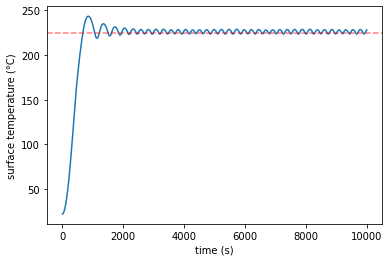

In [ ]:
x,tspan,T_surface,state_list,PID_list, T_list = solve_heat_eqn_PID()
T_surface_plot(tspan,T_surface,225)

We can play around with the parameters to give a different result

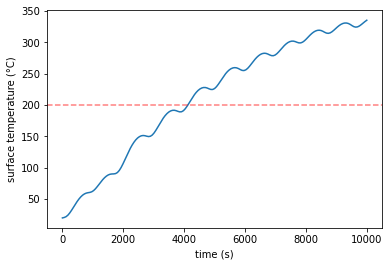

In [ ]:
# example
x,tspan,T_surface,state_list,PID_list, T_list = solve_heat_eqn_PID(
    alpha = 9e-5,
    th = 0.4,
    q_hotplate = 1500,
    h_air = 3,
    num_nodes = 20,
    dt = 60,
    t_max = 10000,
    T_room = 20,
    t_warmup=200,
    cooldown_factor=5,
    kp = 0.1,
    ki = 1,
    kd = 1000,
    setpoint = 200)

T_surface_plot(tspan,T_surface,200)

How good was our simulation? Let's call the PID_metrics function to take a look at some scoring metrics

* **Max temp**: the max temp after reaching the setpoint
* **Min temp**: the min temp after reaching the setpoint
* **Temp range**: The difference between max and min temp. The max amoount of oscillation we see
* **Initial overshoot**: The height of the first peak
* **Time to setpoint**: The amount of time it takes for the first instance of the temperature crossing the setpoint line
* **Initial swing**: The temperature difference between the first peak and the first valley
* **[time] RMSE**: The RMSE between the model and the setpoint for that length of time after reaching the setpoint
* **After 90 min RMSE**: The RMSE between the model and the setpoint for 30 mins, starting 90 mins after reaching the setpoint. Is NAN if the simulation does not go for that long
* **Average Temp**: the average temperature after reaching the setpoint
* **Temp diff**: The difference between the average temperature and setpoint

In [ ]:
PID_metrics(T_surface,setpoint=200,dt=60)

Max temp: 335.2 °C
Min temp: 202.8 °C
Temp range: 132.4 °C
initial overshoot: -48.6 °C
initial swing: 1.7 °C
time to setpoint: 4140 s (index 69)
30 min RMSE: 39.5 °C
60 min RMSE: 65.2 °C
2 hour RMSE: 90.5 °C
after 90 min RMSE: 128.4425 °C
Average temp: 282.5 °C
temp diff: 82.5 °C


We can easily animate the results by calling the animation function I wrote!

In [ ]:
anim = generate_temperature_animation(T_list, x, tspan, T_setpoint=200)
HTML(anim.to_html5_video())

I also made a still frame of the animation that renders much more quickly if you want faster results.

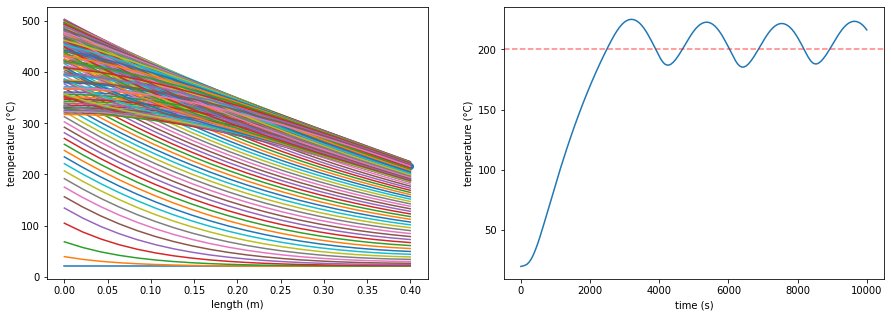

In [ ]:
generate_temperature_plot(T_list,x,tspan,200)